# Goal


The goal is to perform funnel analysis for an e-commerce website.

Typically, websites have a clear path to conversion: for instance, you land on the home page, then you search, select a product and buy it. At each of these steps, some users will drop off and leave the site. The sequence of pages that leads to conversion is called ‘funnel’ .

Data Science can have a tremendous impact on funnel optimization. 
Funnel analysis allows to understand where/when our users abandon the website. It gives crucial insights on user behavior and on ways to improve the user experience as well as it often allows to discover bugs.



In [2]:
import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn import preprocessing

In [414]:
!ls

Funnel_Analysis.ipynb            tree_payment_conf.dot.pdf
all_merged.csv                   tree_payment_conf_mobile.dot
home_page_table.csv              tree_payment_conf_mobile.dot.pdf
payment_confirmation_table.csv   tree_payment_page.dot
payment_page_table.csv           tree_payment_page.dot.pdf
search_page_table.csv            tree_search_page.dot
tree_employee.dot                tree_search_page.dot.pdf
tree_employee.dot.pdf            user_table.csv
tree_payment_conf.dot


Converting 'date' column to datetime format and then splitting it into, month, day of week and year. 

In [415]:
user_table = pd.read_csv('user_table.csv')
print(len(user_table))
user_table.head()
user_table['date'] = pd.to_datetime(user_table['date'])#astype(datetime)
user_table['year'] = pd.DatetimeIndex(user_table['date']).year
user_table['month'] = pd.DatetimeIndex(user_table['date']).month
user_table['day_of_week'] = pd.DatetimeIndex(user_table['date']).dayofweek
user_table.drop(['date'], axis = 1,inplace = True)
user_table.head()

90400


,user_id,device,sex,year,month,day_of_week
0,450007,Desktop,Female,2015,2,5
1,756838,Desktop,Male,2015,1,1
2,568983,Desktop,Male,2015,4,3
3,190794,Desktop,Female,2015,2,2
4,537909,Desktop,Male,2015,1,3


In [416]:
print(user_table['year'].unique())

[2015]


All data is from the year 2015, so we can drop the year column from the user table

In [417]:
user_table.drop(['year'], axis = 1, inplace = True)

In [418]:
home_page_table = pd.read_csv('home_page_table.csv')
print(len(home_page_table), len(home_page_table)/len(home_page_table))
print(home_page_table.head())
search_page_table = pd.read_csv('search_page_table.csv')
print(len(search_page_table), len(search_page_table)/len(home_page_table))
print(search_page_table.head())
payment_page_table = pd.read_csv('payment_page_table.csv')
print(len(payment_page_table), len(payment_page_table)/len(home_page_table))
print(payment_page_table.head())
payment_confirmation_table = pd.read_csv('payment_confirmation_table.csv')
print(len(payment_confirmation_table), len(payment_confirmation_table)/len(home_page_table))
print(payment_confirmation_table.head())

90400 1.0
   user_id       page
0   313593  home_page
1   468315  home_page
2   264005  home_page
3   290784  home_page
4   639104  home_page
45200 0.5
   user_id         page
0    15866  search_page
1   347058  search_page
2   577020  search_page
3   780347  search_page
4   383739  search_page
6030 0.06670353982300885
   user_id          page
0   253019  payment_page
1   310478  payment_page
2   304081  payment_page
3   901286  payment_page
4   195052  payment_page
452 0.005
   user_id                       page
0   123100  payment_confirmation_page
1   704999  payment_confirmation_page
2   407188  payment_confirmation_page
3   538348  payment_confirmation_page
4   841681  payment_confirmation_page


dummy_df is function used to merge all the csvs here based on the user_id and then convert them into one-hot encoding for all pages(0, 1)

In [419]:
def dummy_df(df, df_list):
    for i in df_list:
        df = pd.get_dummies(pd.merge(df, i, on = ['user_id'], how = 'left'), prefix_sep='_', columns = ['page'])
    return df
df_list = [home_page_table, search_page_table, payment_page_table, payment_confirmation_table]
df = dummy_df(user_table, df_list)
df.head()

,user_id,device,sex,month,day_of_week,page_home_page,page_search_page,page_payment_page,page_payment_confirmation_page
0,450007,Desktop,Female,2,5,1,0,0,0
1,756838,Desktop,Male,1,1,1,0,0,0
2,568983,Desktop,Male,4,3,1,1,0,0
3,190794,Desktop,Female,2,2,1,1,0,0
4,537909,Desktop,Male,1,3,1,0,0,0


# A full picture of funnel conversion rate for both desktop and mobile

## Conversion rates for all pages:

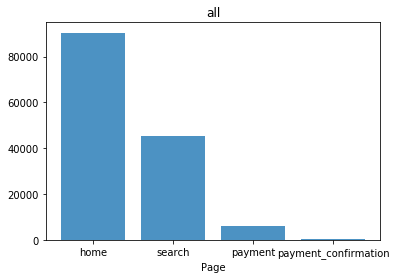

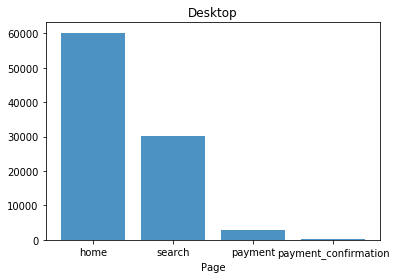

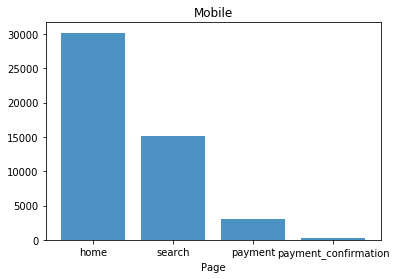

In [420]:
def funnel_chart(df, columns, Title):
    counts = []
    for i in columns:
        counts.append(len(df.loc[df[i] == 1][i]))
    y_pos = np.arange(1,len(counts)+1)
    plt.bar(y_pos, counts, align='center', alpha=0.8)
    plt.xticks(y_pos, ['home', 'search', 'payment', 'payment_confirmation'])
    plt.xlabel('Page')
    plt.title(Title)
    plt.show()
page_list = ['page_home_page', 'page_search_page', 'page_payment_page', 'page_payment_confirmation_page']
funnel_chart(df, page_list, 'all')
funnel_chart(df.loc[df['device'] == 'Desktop'], page_list, 'Desktop')
funnel_chart(df.loc[df['device'] == 'Mobile'], page_list, 'Mobile')

From the charts above we observe that there is more data for desktop than mobile. Therefore, user conversion and funnel analysis for desktop and mobile must be performed separately.

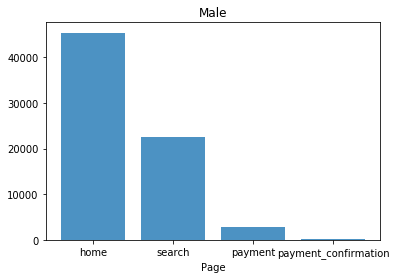

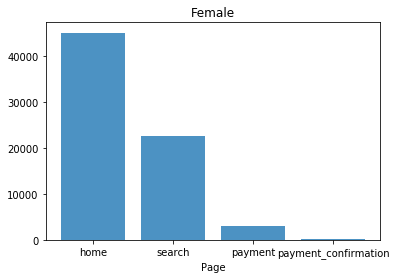

In [421]:
funnel_chart(df.loc[df['sex'] == 'Male'], ['page_home_page', 'page_search_page', 'page_payment_page', 'page_payment_confirmation_page'], 'Male')
funnel_chart(df.loc[df['sex'] == 'Female'], ['page_home_page', 'page_search_page', 'page_payment_page', 'page_payment_confirmation_page'], 'Female')


We dont see a significant difference in the conversion rate between male and female genders

In [422]:
le = preprocessing.LabelEncoder()
le.fit(df['device'])
df['device'] = le.transform(df['device'])

le.fit(df['sex'])
df['sex'] = le.transform(df['sex'])
df.head()

,user_id,device,sex,month,day_of_week,page_home_page,page_search_page,page_payment_page,page_payment_confirmation_page
0,450007,0,0,2,5,1,0,0,0
1,756838,0,1,1,1,1,0,0,0
2,568983,0,1,4,3,1,1,0,0
3,190794,0,0,2,2,1,1,0,0
4,537909,0,1,1,3,1,0,0,0


In [423]:
df.to_csv('all_merged.csv')

# Conversion rate for payment conversion page - Desktop

In [444]:
df_payment_conf_mobile = df.loc[df['device'] == 1].drop(['user_id','device','page_home_page','page_search_page', 'page_payment_page', 'page_payment_confirmation_page'], axis=1)
tree = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 30, class_weight = 'balanced', min_impurity_decrease = 0.001)
tree.fit(df_payment_conf_mobile, df.loc[df['device'] == 1]['page_payment_confirmation_page'])

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.001, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [445]:
export_graphviz(tree, out_file="tree_payment_conf_mobile.dot", feature_names=df_payment_conf_mobile.columns, proportion=True, rotate=True)
with open("tree_payment_conf_mobile.dot") as f:
    dot_graph = f.read()
s = Source.from_file("tree_payment_conf_mobile.dot")
s.view()

'tree_payment_conf_mobile.dot.pdf'

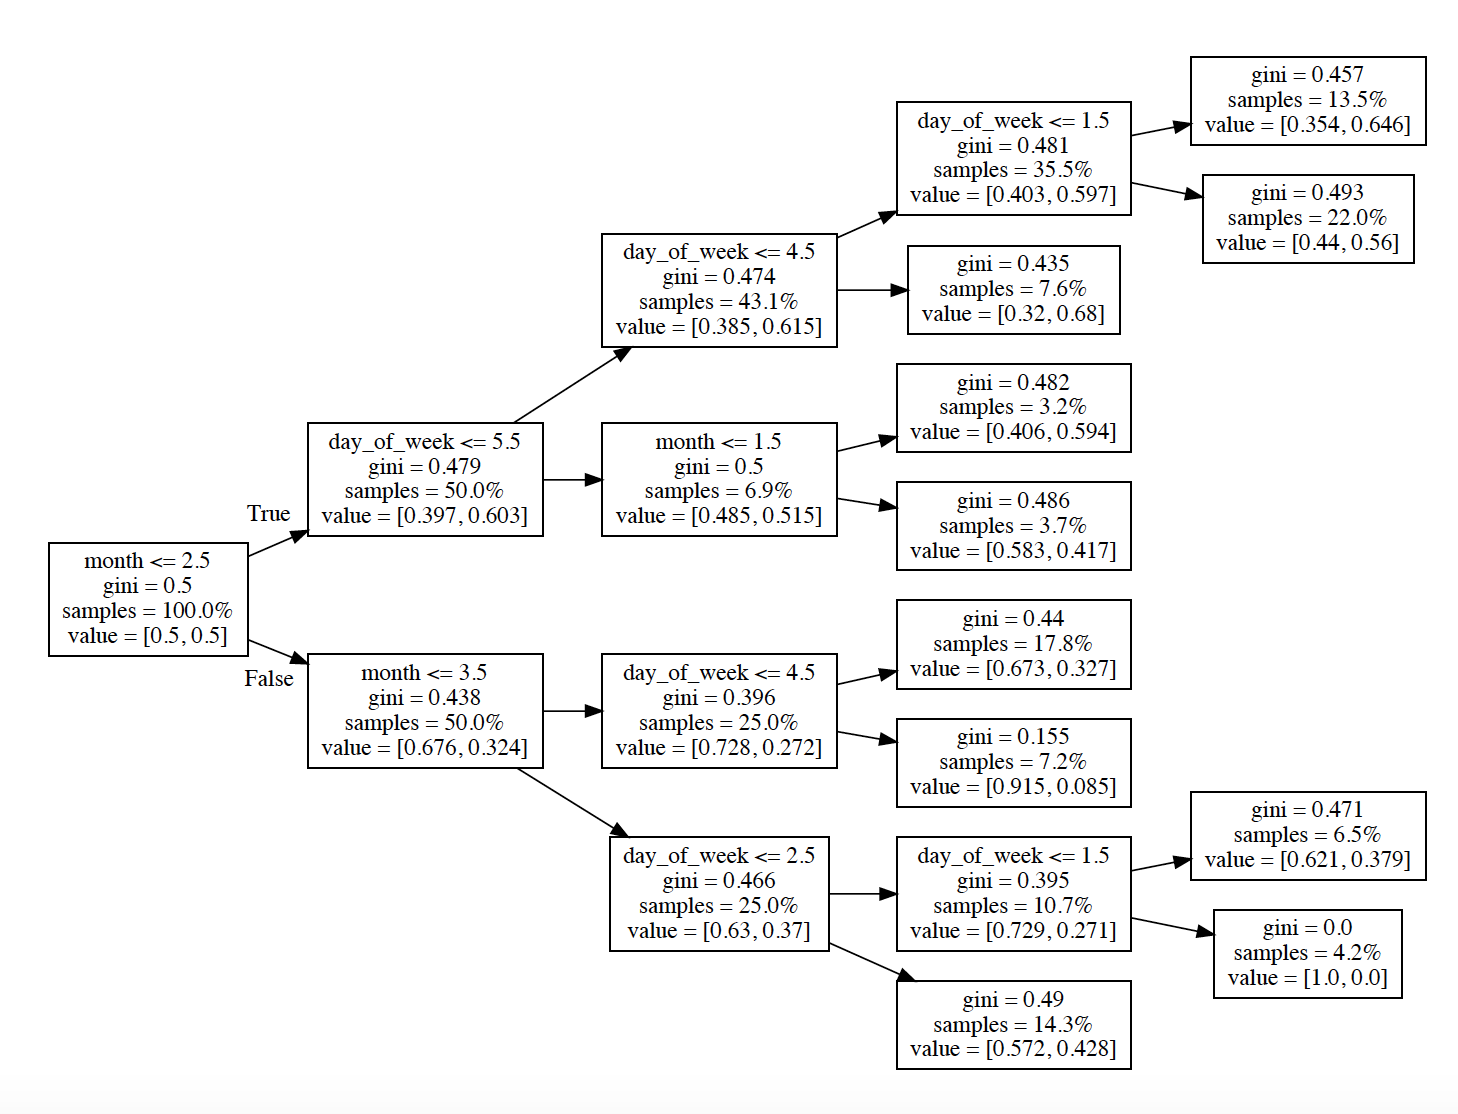

In [4]:
Image(filename='desktop.png')

Observations on the mobile data:
- More purchases occured between Jan to mid March(data only available till end of April)
- Most purchases occured during Monday and Tuesday 
- In order to compare betweeb the performance of mobile and desktop data, we would need equal distributions of data for both devices. This would help understand key drivers in getting a customer from the home page to confirmation page based on the platform the customer is viewing the website from

In [446]:
df_payment_conf_desktop = df.loc[df['device'] == 0].drop(['user_id','device','page_home_page','page_search_page', 'page_payment_page', 'page_payment_confirmation_page'], axis=1)
tree = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 30, class_weight = 'balanced', min_impurity_decrease = 0.001)
tree.fit(df_payment_conf_desktop, df.loc[df['device'] == 0]['page_payment_confirmation_page'])

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.001, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [447]:
export_graphviz(tree, out_file="tree_payment_conf_desktop.dot", feature_names=df_payment_conf_mobile.columns, proportion=True, rotate=True)
with open("tree_payment_conf_desktop.dot") as f:
    dot_graph = f.read()
s = Source.from_file("tree_payment_conf_desktop.dot")
s.view()

'tree_payment_conf_desktop.dot.pdf'

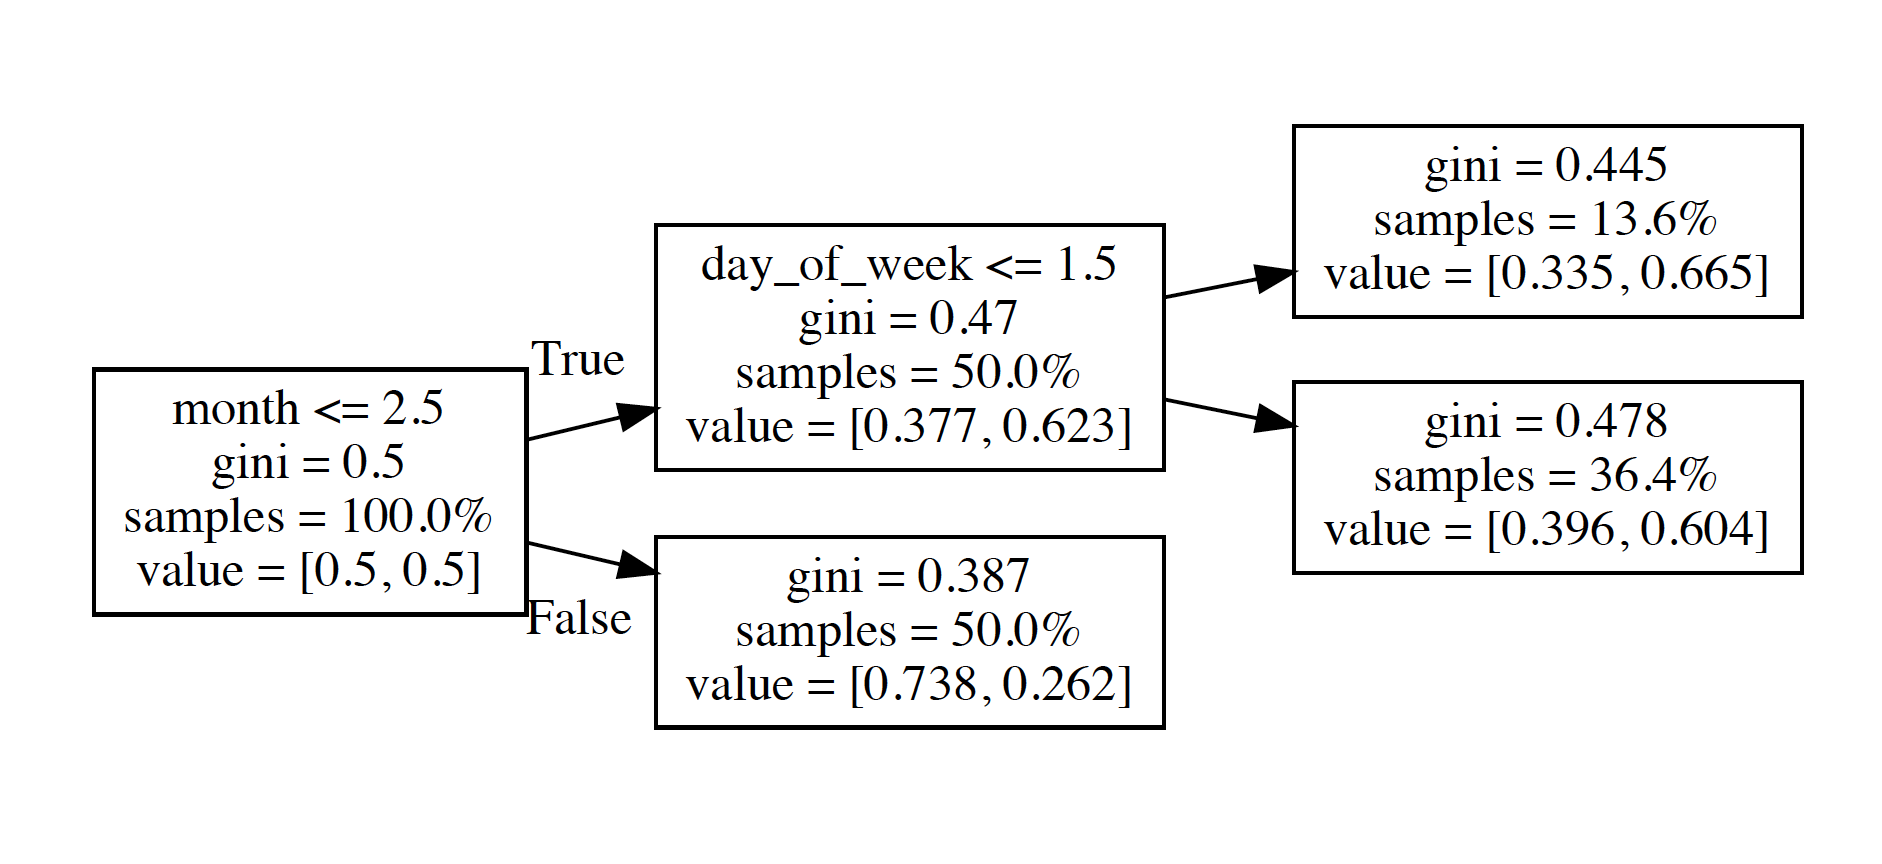

In [3]:
Image(filename='mobile.png')

Observations for desktop:
- Most purchases occured during the weekedays rather than weeekends. 
- We need to look at data spread over a longer period of time to understand customer purchasing behavior
- Try to dive further into why purchases do not tend to occur during the weekends and channel efforts towards improving that behavior
- Overall, there is no difference conversion rate between the two listed genders